# The Challenge

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).





In [31]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder
import seaborn as sn
import matplotlib.pyplot as plt

In [32]:
df = pd.read_csv("../data/Titanic - Machine Learning from Disaster/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [33]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [34]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [35]:
plt.style.use( 'dark_background')

In [36]:
df.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [37]:
pd.crosstab(df.Sex, df.Survived)

Survived,0,1
Sex,,
female,81,233
male,468,109


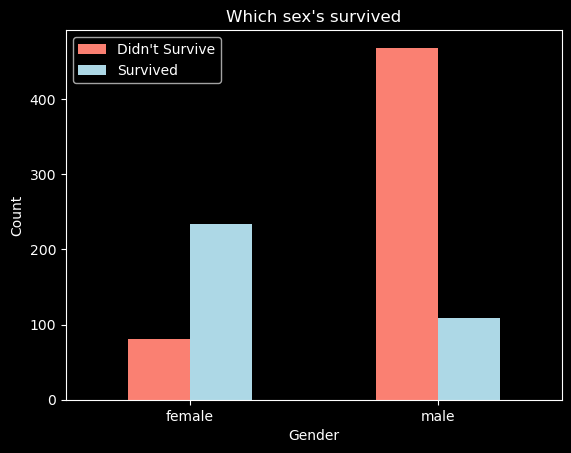

In [38]:
# Lets do some visualizationns and learn more about the data set
# How many males and females
pd.crosstab(df.Sex, df.Survived).plot(kind="bar", color=["salmon", "lightblue"])
plt.legend(["Didn't Survive", "Survived"])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Which sex's survived")
plt.xticks(rotation=0);

In [39]:
# Lets compare the class of people that survived
pd.crosstab(df.Sex, df.Pclass)

Pclass,1,2,3
Sex,,,
female,94,76,144
male,122,108,347


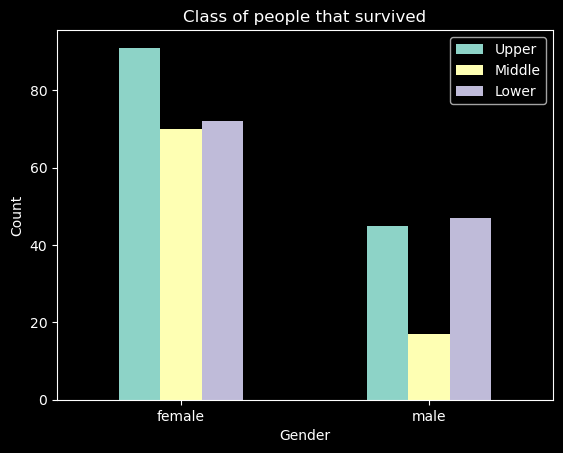

In [40]:
# Why did more of the middle class males die? 

pd.crosstab(df.Sex[df.Survived == 1], df.Pclass).plot(kind="bar");
plt.legend(["Upper", "Middle", "Lower"])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.title("Class of people that survived");

In [41]:
# Since a majority of the age is under 30, we'll make the missing values the median
# Cabin can also be missing
# Embarked can be missing

df.Age.fillna(df.Age.median(), inplace=True)
df.Cabin = df.Cabin.replace({np.nan : "missing"})
df.Embarked = df.Embarked.replace({np.nan: "missing"})
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

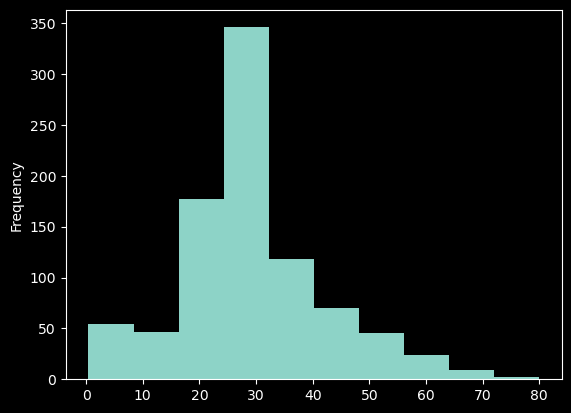

In [42]:
# Lets see a hist of the ages
df.Age.plot.hist();

# Leaning more the younger generation

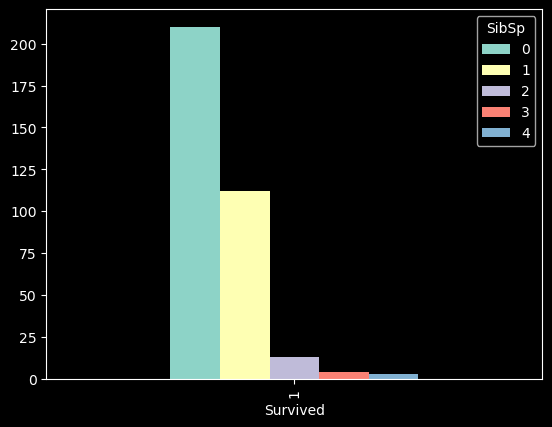

In [43]:
pd.crosstab(df.Survived[df.Survived == 1],  df.SibSp[df.Survived == 1]).plot(kind="bar");

In [44]:
# Lets create a model for the train data and join the dataframes together
len(df)

891

In [45]:
# Use column transformer to transform data in numerical data
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [46]:
features = ["Name", "Sex", "Ticket", "Cabin", "Embarked"]
colum_transform = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), features), 
                                          remainder="passthrough")

In [47]:
# Split the training data
X = df.drop("Survived", axis=1)
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 11), (179, 11), (712,), (179,))

In [59]:
# Lets create our dictionary models and a empty dictionary of scores
model_dict = {
    "SVC": SVC(),
    "KNearest Neighbors": KNeighborsClassifier(n_jobs=-1),
    "Linear SVC": LinearSVC(dual="auto"),
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "Neural Network MLP" : MLPClassifier(max_iter=1000),
}

model_scores = {}

In [60]:
for model_name, model in model_dict.items():
    model = make_pipeline((colum_transform), (model))

    model.fit(X_train, y_train)
    model_scores[model_name] = model.score(X_test, y_test)

highest_score = max(model_scores, key=model_scores.get)
print(f"The highest model is {highest_score}. Score of {model_scores[highest_score]}")

C:\Users\Panache Branding\miniconda3\envs\new_env\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The highest model is Random Forest. Score of 0.8268156424581006


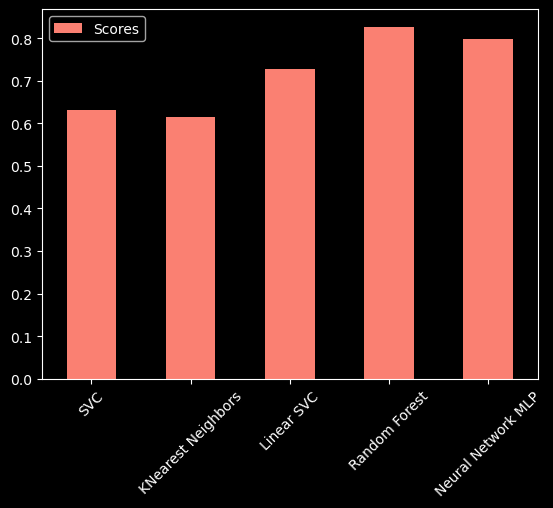

In [62]:
model_df = pd.DataFrame(model_scores, index=["Scores"])
model_df.T.plot.bar(color=["salmon"])
plt.xticks(rotation=45);

In [69]:
# Select the model you will use
clf = make_pipeline((colum_transform), (RandomForestClassifier(n_jobs=1))).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8268156424581006

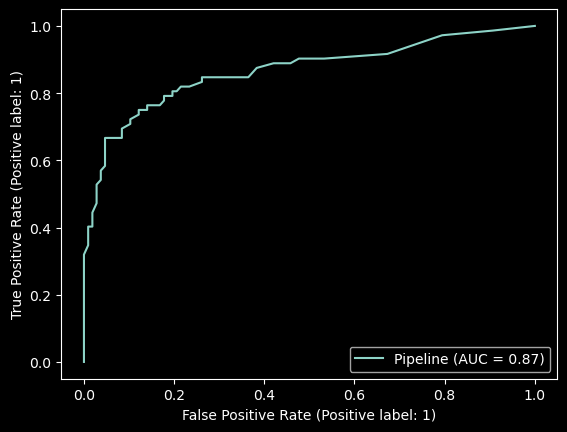

In [70]:
# Lets use the new score to create some metrics
RocCurveDisplay.from_estimator(clf, X_test, y_test);

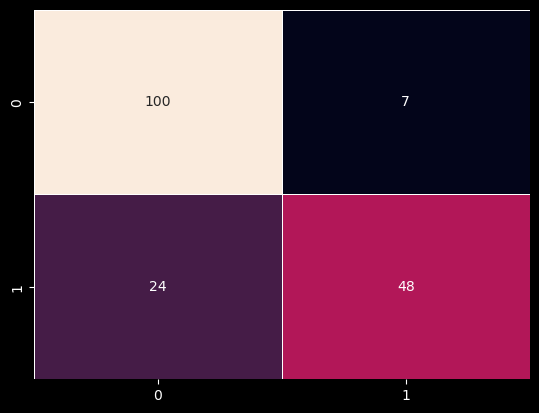

In [71]:
y_preds = clf.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
sn.heatmap(cm, annot=True, linewidths=0.5, cbar=False, fmt=".0f");

In [72]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       107
           1       0.87      0.67      0.76        72

    accuracy                           0.83       179
   macro avg       0.84      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179



In [74]:
# Cross validation score
cv_acc = np.mean(cross_val_score(rs_clf, X, y, cv=5, scoring="accuracy"))
cv_pre = np.mean(cross_val_score(rs_clf, X, y, cv=5, scoring="precision"))
cv_rec = np.mean(cross_val_score(rs_clf, X, y, cv=5, scoring="recall"))
cv_f1 = np.mean(cross_val_score(rs_clf, X, y, cv=5, scoring="f1"))

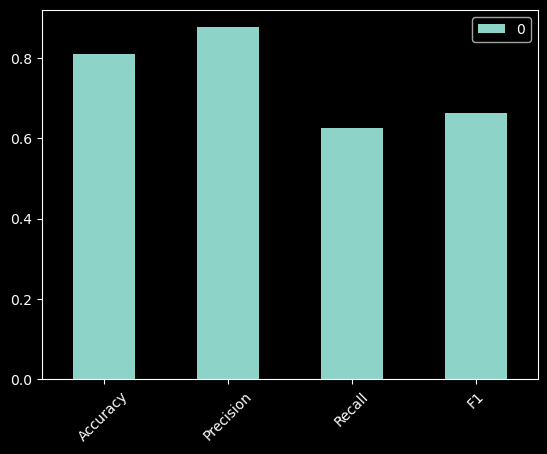

In [82]:
cv_score = {
    "Accuracy": cv_acc,
    "Precision": cv_pre,
    "Recall": cv_rec,
    "F1": cv_f1
}

cv_df = pd.DataFrame(cv_score, index=[0])
cv_df.T.plot(kind="bar")
plt.xticks(rotation=45);